In [1]:
import os
import pickle
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf

from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'


In [3]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [4]:
features = {}
directory = os.path.join(BASE_DIR,"Images")
for img_name in tqdm(os.listdir(directory)):
    img_path = directory + "/" + img_name
    image = load_img(img_path, target_size = (224,224))
    image = img_to_array(image)
    image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    image = preprocess_input(image)
    feature = model.predict(image,verbose = 0)
    image_id = img_name.split(".")[0]
    features[image_id] = feature

    

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
pickle.dump(features,open(os.path.join(WORKING_DIR,"features.h5"),"wb"))

In [6]:
with open(os.path.join(WORKING_DIR,"features.h5"),"rb") as f:
    features = pickle.load(f)
    

In [7]:
print(len(features["3226254560_2f8ac147ea"][0]))
print(len(features))

4096
8091


## Handling captions

In [8]:
with open(os.path.join(BASE_DIR,"captions.txt"),"r") as f:
    next(f)
    captions_doc = f.read()

In [9]:
mapping = {}
for line in tqdm(captions_doc.split("\n")):
    tokens = line.split(",")
    if len(line) < 2:
        continue
    image_id,caption = tokens[0],tokens[1:]
    image_id = image_id.split(".")[0]
    caption = "".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)
    
    

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
print(len(mapping))

8091


In [11]:
print(mapping["3226254560_2f8ac147ea"])

['A dog in a snowy area .', 'A spotted dog catching a ball on a snowy field .', 'A white and brown spotted dog runs along the snow to catch a ball .', 'A white dog is running fast on a trail covered by snow .', 'The brown and white dog is playing in the snow .']


## Preprocessing Text Data

In [12]:
def clean(mapping):
    for key ,captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
#             caption = caption.replace(["^A-Za-z"])
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption
            
            

In [13]:
clean(mapping)

In [14]:
print(mapping["3226254560_2f8ac147ea"])

['startseq dog in snowy area endseq', 'startseq spotted dog catching ball on snowy field endseq', 'startseq white and brown spotted dog runs along the snow to catch ball endseq', 'startseq white dog is running fast on trail covered by snow endseq', 'startseq the brown and white dog is playing in the snow endseq']


In [15]:
all_captions = []
for captions in mapping.values():
    all_captions += captions
        
print(len(all_captions))

40455


In [16]:
#Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)+ 1


In [17]:
vocab_size

8485

In [18]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length


35

In [19]:
image_ids = list(mapping.keys())
split = int(len(image_ids) *0.90)
train = image_ids[:split]
test = image_ids[split:]

In [20]:
#data generator to get data in batch to avoid system crash:
def data_generator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
    X1,X2,y = list(),list(),list()
    n = 0
    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                
                for i in range(1,len(seq)):
                    in_seq ,out_seq = seq[:i],seq[i]
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    out_seq = to_categorical([out_seq],num_classes = vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
                if n == batch_size:
                    X1,X2,y = np.array(X1),np.array(X2),np.array(y)
                    yield [X1, X2], y
                    X1, X2, y = list(),list(),list()
                    n = 0
                    
                    
                    
                

## Model Creation


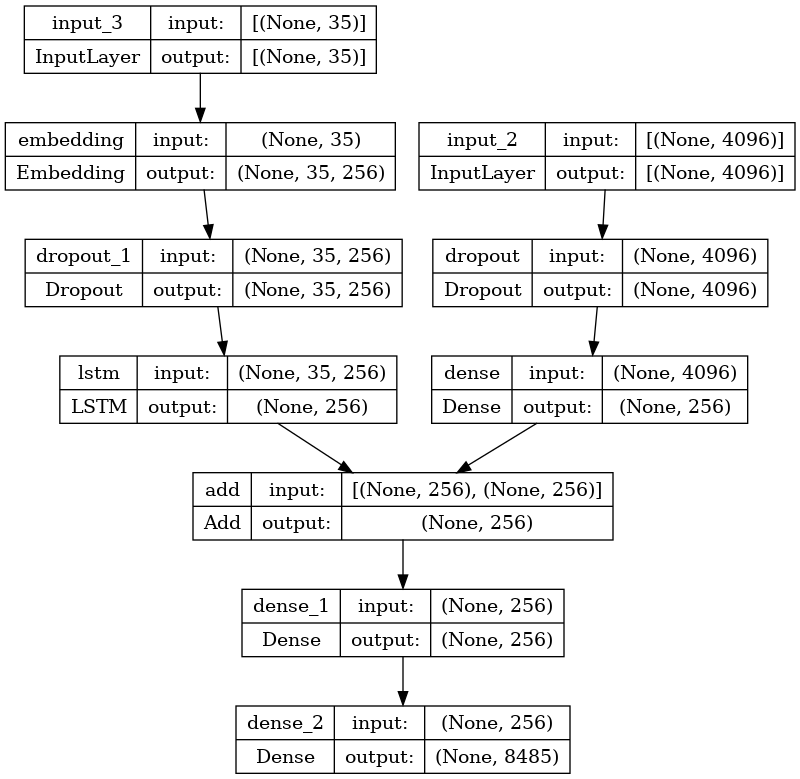

In [21]:
#encoder model
inputs1 = Input(shape = (4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256,activation = "relu")(fe1)

inputs2 = Input(shape = (max_length,))
se1 = Embedding(vocab_size,256,mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2,se3])
decoder2 = Dense(256,activation = "relu")(decoder1)
outputs = Dense(vocab_size,activation="softmax")(decoder2)

model = Model(inputs = [inputs1,inputs2], outputs = outputs)
model.compile(loss = "categorical_crossentropy", optimizer = "adam")

plot_model(model,show_shapes = True)


In [22]:
# train model 
epochs = 15
batch_size = 32
steps = len(train)// batch_size

for i in range(epochs):
    generator = data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
    
    model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose =1)

227/227 [==============================] - 71s 312ms/step - loss: 2.3537


In [23]:
model.save(WORKING_DIR+'/best_model.h5')

In [24]:
#load model
# model = tf.keras.saving.load_model("/kaggle/input/caption-generation-model/best_model.h5")

In [25]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 256)      2172160     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

In [26]:
def idx_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [27]:
# generate caption for an image
def predict_caption(model,image,tokenizer,max_length):
    in_text = "startseq"
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],max_length)
        yhat = model.predict([image,sequence],verbose = 0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat,tokenizer)
        if word is None :
            break
        in_text += " " + word
        
        if word == "endseq":
            break
            
    return in_text    
        
        

In [28]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.547597
BLEU-2: 0.321625


In [29]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)


---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing in the snow endseq


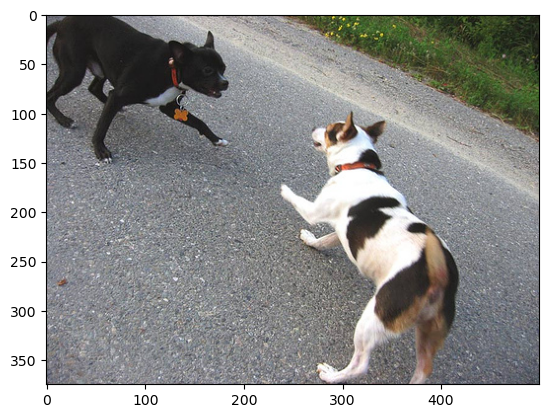

In [30]:
generate_caption("1001773457_577c3a7d70.jpg")

In [50]:
test_path = "/kaggle/input/test-images2/test.png"

In [54]:
def get_features(test_path,model1):
    image = load_img(test_path, target_size = (224,224))
    image = img_to_array(image)
    image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    image = preprocess_input(image)
    feature = model1.predict(image,verbose = 0)
    return feature

vgg_model = VGG16()
vgg_model = Model(inputs = vgg_model.inputs, outputs = vgg_model.layers[-2].output)



startseq dog is running through the air endseq


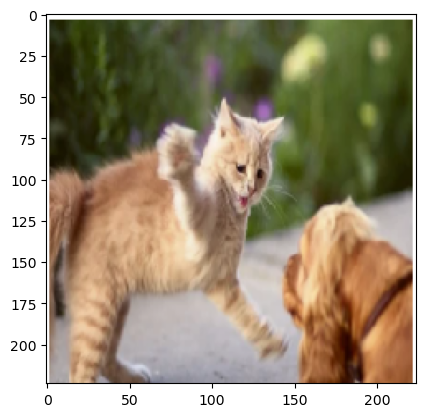

In [55]:
feature1 = get_features(test_path,vgg_model)
captions = predict_caption(model,feature1,tokenizer,max_length)
print(captions)
  
test_img = load_img(test_path, target_size = (224,224))
plt.imshow(test_img)